# Data Analysis for Data-Driven Water Temperature Prediction 

- Analysing the dataset created by run_example.sh
- Modelling statistical predictions



TODO:
 - Tune processing and storing of observational data sets (to suite whatever code that will use the data sets)
 - Prototype naive prediction
 - Prototype linear regression
 - Prototype random forest
 - Prototype simple XGBoost
 - Prototype simple ANN (with Tensorflow and Keras?)
 - ...

In [1]:
import pandas as pd 
import datetime
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
mydates = mdates.DateFormatter('%m-%d')

## Reading and Preprocessing data set 

In [2]:
# Read the example data
data = pd.read_csv("example_dataset.csv")
N = len(data)

data["time"] = pd.to_datetime(data["time"])
data = data.set_index("time")

years = list(dict.fromkeys(list(data.index.year)))

In [3]:
# NOTE: Some of the libraries require special attention if the data contains NaNs
# For the time being we just remove those 

# Check the dataset for sanity 
# i.e. remove columns with only NaN
for column in data.columns:
    if data[column].isnull().values.any():
        print("Column", column, "gets removed since it contains NaN entries")
        del data[column]



Column SN19940wind_speed1 gets removed since it contains NaN entries
Column SN18700cloud_area_fraction1 gets removed since it contains NaN entries


In [4]:
# NOTE: Some columns contain only integer values

# Casting to all entries to floats
for column in data.columns:
    if data[column].dtype != "float64":
        data[column] = data[column].astype(float)

In [5]:
# Adding the previous water_temp as additonal trainings covariate
data["LASTwater_temp"] = data["water_temp"].shift(1)
data = data.iloc[1:, :]

In [6]:
# Split in train and test data
# where the full last year becomes the test set 
start_train = datetime.datetime.strptime(str(years[0])+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
end_train = datetime.datetime.strptime(str(years[-1]-1)+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
train = data[start_train : end_train]

start_test = datetime.datetime.strptime(str(years[-1])+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
end_test = datetime.datetime.strptime(str(years[-1])+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
test = data[start_test : end_test]

## Data Exploration

Functionalities for the plotting of time series 

In [7]:
def plot_timeseries_all_years(param):
    """Plotting timeseries of the param column 
    for all years in the data set 
    over the same date in year x-axis"""
    fig, ax = plt.subplots()
    for year in years:
        print(year)
        start_time = datetime.datetime.strptime(str(year)+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
        end_time = datetime.datetime.strptime(str(year)+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
        ax.plot(data.loc[start_time:end_time].reset_index()["time"]+pd.offsets.DateOffset(year=2000),
            data[param].loc[start_time:end_time])

    ax.xaxis.set_major_formatter(mydates)
    plt.legend(years)
    plt.xlabel("date [MM-DD]")
    plt.ylabel(param)
    plt.title("Time series")


2017
2018
2019
2020
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


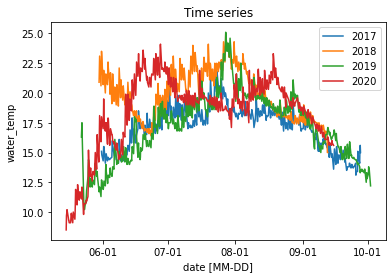

In [8]:
plot_timeseries_all_years("water_temp")

## Data Analysis

Learning a data-driven predictor

In [9]:
def plot_test_vs_truth(predicition):
    """Plotting timeseries of the prediciton against the truth"""
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    # Time series plot
    test["water_temp"].plot(ax=axs[0])
    prediction.plot(ax=axs[0])

    axs[0].legend(["truth","prediction"])
    axs[0].set_xlabel("date")
    axs[0].set_ylabel("water_temp [degC]")
    axs[0].set_title("True time series vs predicted on test set")

    # Bias plot
    axs[1].plot(prediction, test["water_temp"], "+")
    axs[1].plot(np.linspace(8,24), np.linspace(8,24))

    axs[1].set_xlabel("predicted water_temp [degC]")
    axs[1].set_ylabel("true water_temp [degC]")
    axs[1].set_title("Predicted test vs true test")    


### Naive Prediction

The naive prediction assumes that the `water_temp` does not change

In [10]:
prediction = test["LASTwater_temp"].shift(1) 

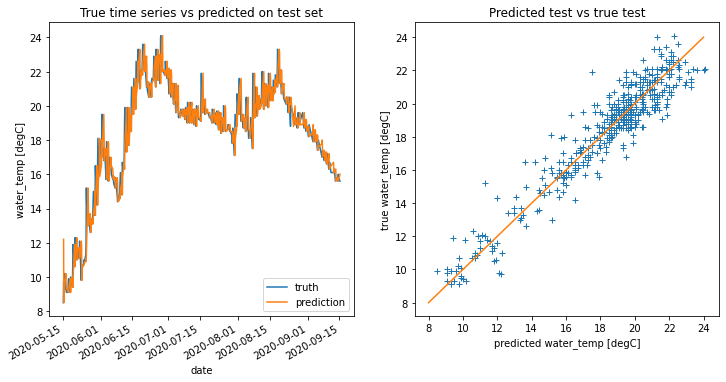

In [11]:
plot_test_vs_truth(prediction)


### NorKyst800 Prediction

Relying on NorKyst800 Forecast without further data analysis


In [12]:
prediction = test["THREDDSnorkysttemperature0"]

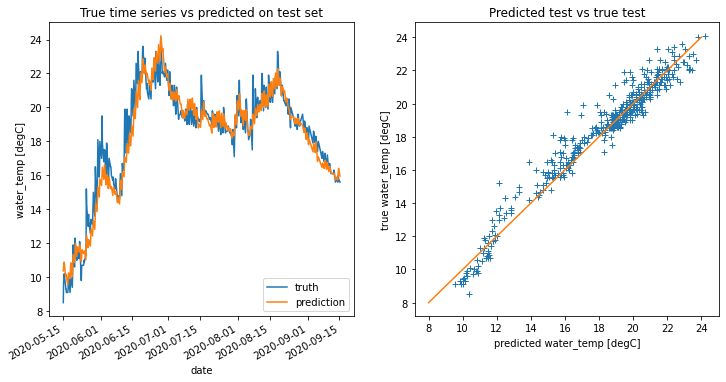

In [13]:
plot_test_vs_truth(prediction)

### Regressoion-Type Algorithms

The atmospheric observations at time $t$, the NorKyst800 forecast for time $t$ and the `water_temp` at time $t-1$ are used as covariates in order to model the `water_temp` at time $t$ as response.

NOTE: 
- the increments between times is different! An additional time difference variable could be useful, but does not make sense additive linear factor (as multiplicative factor maybe more suited - DISCUSS)
- in further work, we aim for atmospheric observations at time $t-1$ and forecasted atmospheric elements at time $t$

In [14]:
# Covariates and response
X = train.loc[:, data.columns!="water_temp"]
Y = train["water_temp"]

#### Linear Regression


In [15]:
from sklearn.linear_model import LinearRegression

# Train linear regression model
linreg = LinearRegression()
linreg.fit(X,Y)

LinearRegression()

In [16]:
# Test model
prediction_labels = linreg.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

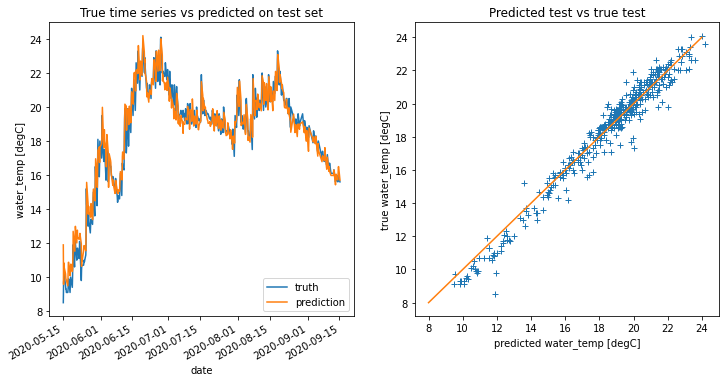

In [17]:
plot_test_vs_truth(prediction)

#### Random Forest

We use all default settings (`n_ensembles` aka the number of trees = 100, `max_features` aka the number of features to split on = sqrt(n_features))

In [18]:
from sklearn.ensemble import RandomForestRegressor
# train model
rf = RandomForestRegressor()
rf.fit(X,Y)

RandomForestRegressor()

In [19]:
# Test model
prediction_labels = rf.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

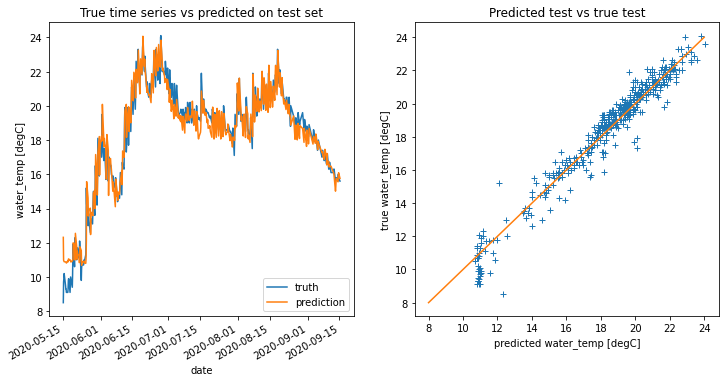

In [20]:
plot_test_vs_truth(prediction)

In [21]:
importance_values = rf.feature_importances_
importance = pd.DataFrame(importance_values, columns=["importance"])
importance["element"] = X.columns
importance = importance.set_index("element")
importance = importance.sort_values(by="importance", ascending=False)
importance

,importance
element,
LASTwater_temp,0.907476
THREDDSnorkysttemperature0,0.024074
SN19430air_temperature0,0.014563
SN19923air_temperature0,0.012719
SN19710air_temperature0,0.012666
SN19940air_temperature0,0.007917
SN19940mean(surface_downwelling_shortwave_flux_in_air PT1H)0,0.004977
SN19923wind_speed0,0.002829
SN19940wind_speed0,0.002345


#### XGBoost

Using only default, however parameter tuning would be important for boosting though.


In [22]:
from xgboost import XGBRegressor
# train model
xgb = XGBRegressor()
xgb.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=72, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
# Test model
prediction_labels = xgb.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


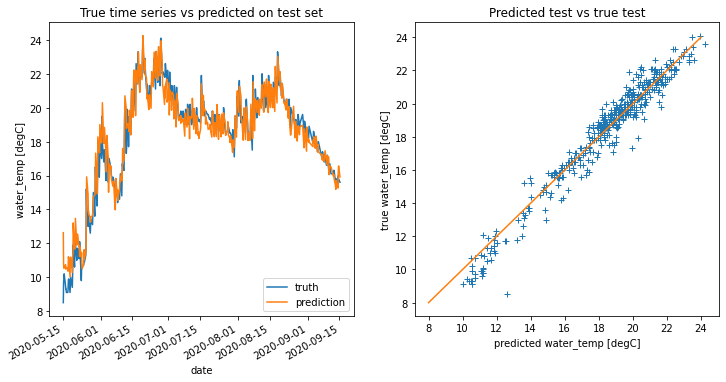

In [24]:
plot_test_vs_truth(prediction)

### Neural Nets

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# NOTE: without a normalizer the results are shifted
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

# Building the neural net
# NOTE: The design of the net has major influence on the results!
# For details see documentation of tensorflow
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(5),
    layers.Dense(units=1)
])

# Configuring with loss function and optimization algorithm
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Training
# NOTE: The training results are very random such that the results from every run are fundamentally different
model.fit(X, Y,
    epochs=200,
    verbose=0,
    validation_split = 0.2)

In [26]:
#test
prediction_labels = model.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

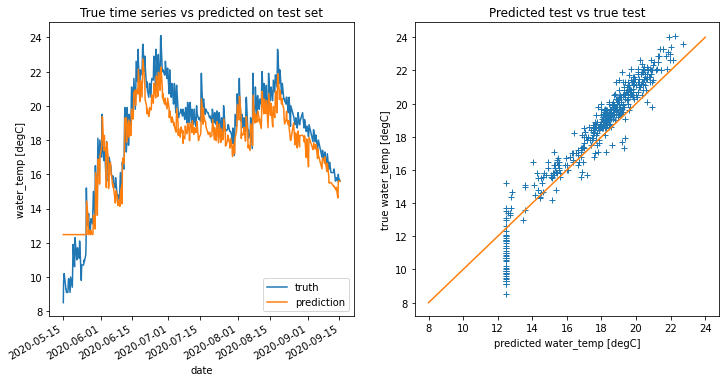

In [27]:
plot_test_vs_truth(prediction)